# EDA

During this explorataru analysis questions we want to overview datasets and answer the questions:
- Which leagues are in which countries?
- How many teams are present in each league? 
- Which league has the most team?
- Which leagues score the most/fewest goals?
- Is there such a thing as home advantage?

In [1]:
import sqlite3
from sqlite3 import connect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import os
import itertools
from datetime import datetime
import xml.etree.ElementTree as ET
import statsmodels.api as sm
import math

from generic_functions import extract_xml, end_of_year_player, end_of_year_team, team_to_player_home, team_to_player_away, team_to_player, top_N_team, league_to_team, top_leagues, box_plot_leagues
    

In [2]:
os.getcwd()

'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone'

## Leagure overview

In [3]:
input_path = "/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Input/database.sqlite"
con = sqlite3.connect(input_path)

table = pd.read_sql('''
            SELECT * FROM sqlite_master 
            WHERE TYPE = 'table'; ''',con)

### Which leagues are in which countries?

In [4]:
cl_df = pd.read_sql_query("""
            SELECT 
                DISTINCT C.name AS country_name,
                L.name AS league_name
            FROM League AS L 
            LEFT JOIN Country AS C
                ON L.country_id = C.id
            ORDER BY country_name, league_name""", con)

cl_df

,country_name,league_name
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


<b>Highlight</b>: There is 11 leagues in 11 countries.

### How many teams are present in each league? 

In [5]:
df_m = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/matches.csv")
df_m.info()
df_m.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 121 entries, id_x to away_team_short_name
dtypes: float64(96), int64(9), object(16)
memory usage: 24.0+ MB


,id_x,country_id,league_id_x,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBA,BSH,BSD,BSA,country,league,home_team_long_name,home_team_short_name,away_team_long_name,away_team_short_name
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,4.00,1.73,3.40,4.2,Belgium,Belgium Jupiler League,KRC Genk,GEN,Beerschot AC,BAC
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,3.75,1.91,3.25,3.6,Belgium,Belgium Jupiler League,SV Zulte-Waregem,ZUL,Sporting Lokeren,LOK


In [6]:
print(list(df_m.columns))

['id_x', 'country_id', 'league_id_x', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_pla

In [7]:
conn = connect(':memory:')
df_m.to_sql('df_matches', conn)

clt_df = pd.read_sql("""
    SELECT 
        DISTINCT country,
        league,
        home_team_long_name,
        home_team_short_name
    FROM df_matches
    """,conn)
clt_df.head(5)

,country,league,home_team_long_name,home_team_short_name
0,Belgium,Belgium Jupiler League,KRC Genk,GEN
1,Belgium,Belgium Jupiler League,SV Zulte-Waregem,ZUL
2,Belgium,Belgium Jupiler League,KSV Cercle Brugge,CEB
3,Belgium,Belgium Jupiler League,KAA Gent,GEN
4,Belgium,Belgium Jupiler League,FCV Dender EH,DEN


In [8]:
print('Checking whether single team plays in single league:')

check = (clt_df.groupby('home_team_long_name')
                 .agg(Occur=('league','nunique'))
                 .sort_values(by='Occur',
                              ascending=False))
check.head(5)

Checking whether single team plays in single league:


,Occur
home_team_long_name,
1. FC Kaiserslautern,1
RCD Mallorca,1
RC Recreativo,1
RC Lens,1
RC Deportivo de La Coruña,1


In [9]:
print("Number of teams present in league:")
teams_per_c = (clt_df.groupby(['country','league'])
                   .agg(NumTeam=('home_team_long_name','nunique'))
                   .reset_index()
        )
teams_per_c.sort_values(by='NumTeam',ascending=False)

Number of teams present in league:


,country,league,NumTeam
2,France,France Ligue 1,35
1,England,England Premier League,34
9,Spain,Spain LIGA BBVA,33
4,Italy,Italy Serie A,32
3,Germany,Germany 1. Bundesliga,30
7,Portugal,Portugal Liga ZON Sagres,29
5,Netherlands,Netherlands Eredivisie,25
0,Belgium,Belgium Jupiler League,24
6,Poland,Poland Ekstraklasa,22
8,Scotland,Scotland Premier League,17


### Which league has the most team?

<b>Highlight:</b> Most of the countries and leagues has similar high number of teams. Around 30 teams.

Most teams having leagues are:
- France Ligue 1 (35), 
- England Premier League (34),
- Spain LIGA BBVA (33)

Least teams having leagues are:
- Switzerland Super League (15)
- Scotland Premier League (17)
- Poland Ekstraklasa (22)

### Which leagues score the most/fewest goals?

In [10]:
ls_df = pd.read_sql("""
        SELECT 
            SUBSTRING(date,0,5) AS year,
            country,
            league,
            SUM(home_team_goal + away_team_goal) AS total_goals
        FROM df_matches
        GROUP BY 1,2,3
        ORDER BY year ASC, total_goals DESC
    """,conn)
ls_df.head(5)

,year,country,league,total_goals
0,2008,England,England Premier League,512
1,2008,Netherlands,Netherlands Eredivisie,474
2,2008,Spain,Spain LIGA BBVA,470
3,2008,Germany,Germany 1. Bundesliga,462
4,2008,Belgium,Belgium Jupiler League,437


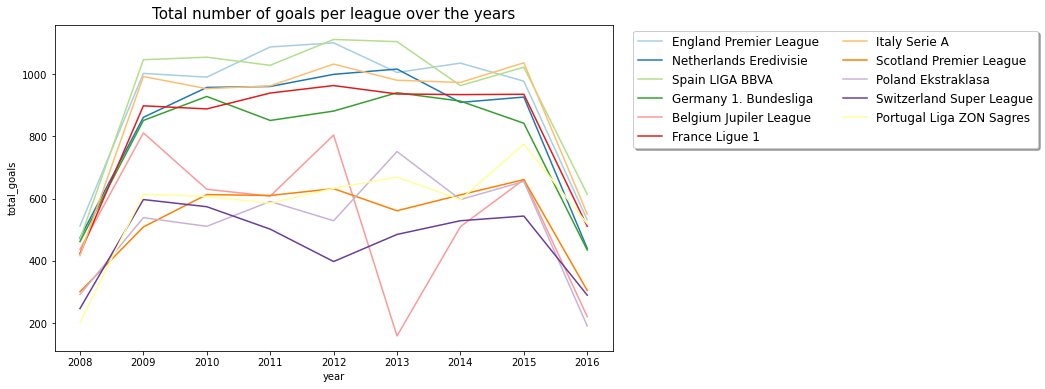

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(data=ls_df, 
            x="year",
            y="total_goals", 
            hue="league",
            palette="Paired"
           )
plt.title("Total number of goals per league over the years", fontsize = 15)
ax.legend(loc='upper center', bbox_to_anchor = (1.4, 1),
          ncol = 2, fancybox = True, shadow = True, fontsize = 12)

<b>Highlight:</b> The most goals scores leagues:
- Spain LIGA BBVA, 
- England Premier League, 
- Italy Serie A 
- Netherlands Eredivisie

The fewest goals scores leagues:
- Switzerland Super League
- Poland Ekstraklasa
- Scotland Premier League
- Belgium Jupiler League

Portugal Liga ZON Sagres is also among fewest goals scoring leagues. 

The fewest goals corring leagues have least teams within them. So the team amount per league could impact total goal scores. Less teams, less matches, less goals.

To see which league is actually scoring better, we need to compare medians, means and other statistics.

In [12]:
total_ls_df = (ls_df.groupby(['country','league'])
                        .agg(TotalGoals=('total_goals','sum'))
                        .reset_index()
                        .sort_values(by='TotalGoals',
                                    ascending=False))


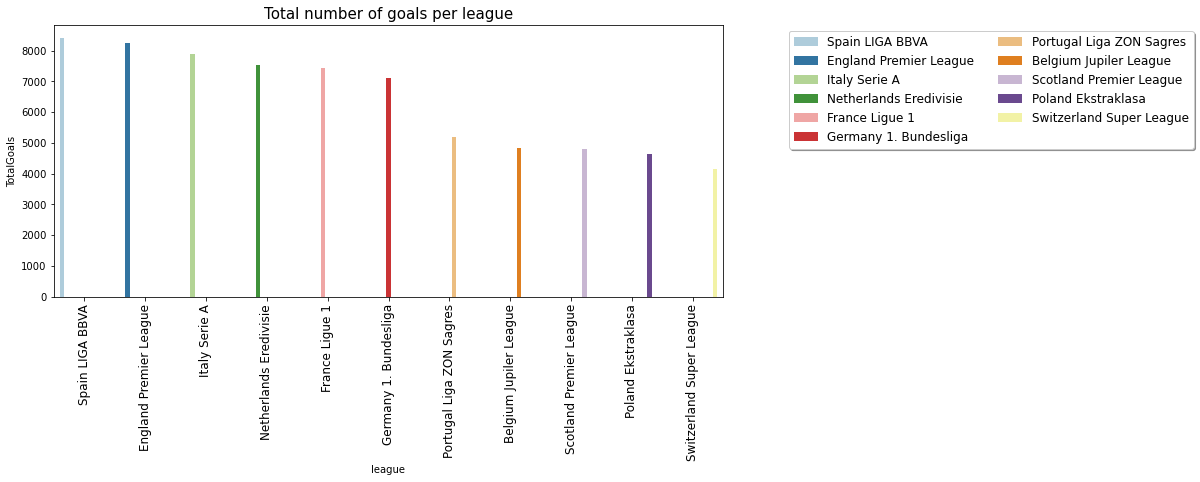

In [13]:
fig, ax = plt.subplots(figsize = (12,5))

sns.barplot(data = total_ls_df, 
            x = "league",
            y = "TotalGoals", 
            hue = "league",
            palette="Paired"
           )
plt.title("Total number of goals per league", fontsize = 15)
ax.legend(loc='upper center', bbox_to_anchor = (1.4, 1),
          ncol = 2, fancybox = True, shadow = True, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 12)
plt.show()

<b>Highlight:</b> A similar situation of leagues order by total goals we can see in the graph above.

<b>Leagues goals statistics:</b>

In [14]:
lsm_df = pd.read_sql("""
        SELECT 
            SUBSTRING(date,0,5) AS year,
            country,
            league,
            home_team_goal + away_team_goal AS goals
        FROM df_matches
    """,conn)
lsm_df.head(5)

,year,country,league,goals
0,2008,Belgium,Belgium Jupiler League,2
1,2008,Belgium,Belgium Jupiler League,0
2,2008,Belgium,Belgium Jupiler League,3
3,2008,Belgium,Belgium Jupiler League,5
4,2008,Belgium,Belgium Jupiler League,4


In [15]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)
# 50th Percentile
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)

In [16]:
lsm_df_stats = (lsm_df.groupby(['country','league'])
                    .agg({'goals': ['min',q25,q50,q75,'max','mean']})
               )
lsm_df_stats = pd.DataFrame(lsm_df_stats.to_records())

lsm_df_stats.rename(columns={"('goals', 'min')": "goals_min", \
            "('goals', 'q25')": "goals_q25", \
            "('goals', 'q50')": "goals_q50", \
            "('goals', 'q75')": "goals_q75", \
            "('goals', 'max')": "goals_max", \
            "('goals', 'mean')": "goals_mean" }
            , inplace=True)
lsm_df_stats = lsm_df_stats.sort_values(by='goals_mean',ascending=False)
lsm_df_stats

,country,league,goals_min,goals_q25,goals_q50,goals_q75,goals_max,goals_mean
5,Netherlands,Netherlands Eredivisie,0,2.00,3.0,4.0,10,3.080882
10,Switzerland,Switzerland Super League,0,2.00,3.0,4.0,9,2.929677
3,Germany,Germany 1. Bundesliga,0,2.00,3.0,4.0,11,2.901552
0,Belgium,Belgium Jupiler League,0,2.00,3.0,4.0,9,2.801505
9,Spain,Spain LIGA BBVA,0,1.75,3.0,4.0,12,2.767105
1,England,England Premier League,0,1.00,3.0,4.0,10,2.710526
8,Scotland,Scotland Premier League,0,1.00,2.0,4.0,12,2.633772
4,Italy,Italy Serie A,0,1.00,2.0,4.0,9,2.616838
7,Portugal,Portugal Liga ZON Sagres,0,1.00,2.0,4.0,9,2.534600
2,France,France Ligue 1,0,1.00,2.0,3.0,10,2.443092


<b>Highlight:</b> Based on median there is no big gap between leagues matches goals medians (match goal median is eitheir 2 or 3).  Other statistics also does not differ that much (p25, p75).

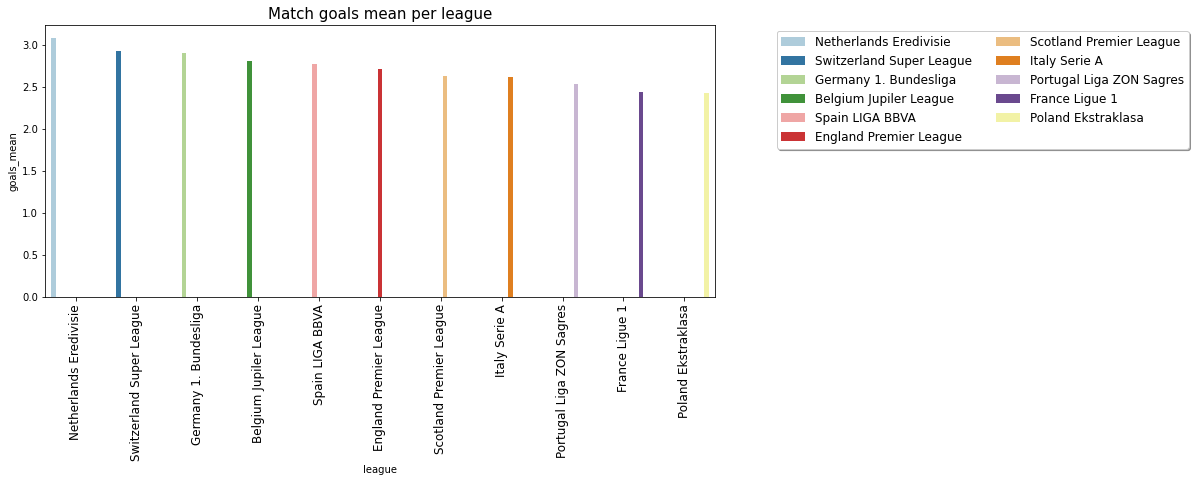

In [17]:
fig, ax = plt.subplots(figsize = (12,5))

sns.barplot(data = lsm_df_stats, 
            x = "league",
            y = "goals_mean", 
            hue = "league",
            palette="Paired"
           )
plt.title("Match goals mean per league", fontsize = 15)
ax.legend(loc='upper center', bbox_to_anchor = (1.4, 1),
          ncol = 2, fancybox = True, shadow = True, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 12)
plt.show()

<b>Highlight:</b> Best matches goals mean is on:
- Netherlands Eredivisie (3.1)
- Switzerland Super League (2.9)
- Germany 1. Bundesliga (2.9)

Lowest matches goals mean is on:
- Poland Ekstraklasa (2.4)
- France Ligue 1 (2.4)
- Portugal Liga ZON Sagres (2.5)

### Top teams amd league by players ratings

We will use players overall rating to evaluate top teams and top leagues.
We will asume if the team/laegue has the best rating playes, they should perform great, too.

For this reason we will extract players from the macth dataset and assign them to the teams and leagues they belong. We will map players ratings.

Then we will list teams and count their players ratings sum and median to find top best ratings having teams.
Similar approach will be applief for the leagues.

In [22]:
df_p = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/players.csv")
df_p.head(2)

df_t = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/teams.csv")
df_t.head(2)

df_m = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/matches.csv")
df_m = df_m.rename(columns={'league_id_x':'league_id'})
df_m.head(2)

df_l = pd.read_sql_query("""
            SELECT 
                *
            FROM League AS L 
            """, con)

df_l.head(2)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League


<b>Top 5 teams based on their players ratings</b>

In [20]:
df = top_N_team(df_t,df_p,df_m,season="2015/2016")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank1"},inplace=True)
df_rank = df
df

,rank1,team_api_id,overall_rating,team_long_name
0,1,8634,1272.0,FC Barcelona
1,2,8633,1267.0,Real Madrid CF
2,3,8455,1264.0,Chelsea
3,4,8456,1263.0,Manchester City
4,5,9906,1262.0,Atlético Madrid


<b>Top leagues based on teams players ratings sum</b>

In [88]:
df = top_leagues(df_t,df_p,df_m,season="2015/2016")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
df_l.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,df_l,on="league_id")
df.sort_values("overall_rating")

,league_id,team_api_id,overall_rating,country_id,name
10,24558,100835,9702.0,24558,Switzerland Super League
8,19694,116853,12524.0,19694,Scotland Premier League
6,15722,115904,16607.0,15722,Poland Ekstraklasa
0,1,427067,18869.0,1,Belgium Jupiler League
7,17642,311550,19606.0,17642,Portugal Liga ZON Sagres
5,13274,185965,22464.0,13274,Netherlands Eredivisie
3,7809,181708,23075.0,7809,Germany 1. Bundesliga
2,4769,205902,25195.0,4769,France Ligue 1
4,10257,410448,26102.0,10257,Italy Serie A
9,21518,207223,26963.0,21518,Spain LIGA BBVA


<b>Top leagues based on teams players ratings median</b>

In [91]:
df = top_leagues(df_t,df_p,df_m,season="2015/2016")
df = df.groupby("league_id").median()
df.reset_index(level=0, inplace=True)
df = pd.merge(df,df_l,on="league_id")
df_l.rename( columns={"id":"league_id" },inplace=True)
df.sort_values("overall_rating")

,league_id,team_api_id,overall_rating,country_id,name
8,19694,8597.0,957.0,19694,Scotland Premier League
10,24558,10184.5,962.5,24558,Switzerland Super League
6,15722,8025.0,987.0,15722,Poland Ekstraklasa
0,1,9985.5,1043.5,1,Belgium Jupiler League
5,13274,8640.0,1062.0,13274,Netherlands Eredivisie
7,17642,9770.0,1062.5,17642,Portugal Liga ZON Sagres
2,4769,9748.0,1096.0,4769,France Ligue 1
4,10257,8686.0,1122.0,10257,Italy Serie A
3,7809,8721.5,1147.0,7809,Germany 1. Bundesliga
1,1729,8668.0,1159.0,1729,England Premier League


## Is there such a thing as home advantage?

Home advangate we could interprete as more goals scorring, more shots made to the gates. 

#### Based on shoton

In match dataset we have attribute shoton:
"Shoton" a shot that enters the goal or would have entered the goal if it had not been blocked by the goalkeeper or another defensive player. We will use this attribute to measure team performance.


To test if teams playing at home performs better we will for statement 

<b><i>Home league team shots (shoton) more often significantly than away league team</i></b>

and we will raise hypothesis:

<b>H0: Shoton number difference means between Home and Away league teams is equal.</b> (μ1=μ2)

<b> H1: Shoton number difference means between Home and Away league teams is significant different from 0. (μ1≠μ2) </b>


In match data set there is many empty, missing values. For this analysis we fill the missing values.

In [19]:
for attribute in ["home_player_X", "away_player_X", "home_player_", "away_player_", "home_player_Y", "away_player_Y"]:
    for number in range(1,2):
        variable = str(attribute) + "" + str(number)
        null_match_instances = df_m[df_m[variable].isnull()].index
        df_m.drop(null_match_instances,inplace=True)
        df_m[variable] = df_m[variable].astype(int)

In [20]:
df_m.isnull().sum()

id_x                    0
country_id              0
league_id_x             0
season                  0
stage                   0
                       ..
league                  0
home_team_long_name     0
home_team_short_name    0
away_team_long_name     0
away_team_short_name    0
Length: 121, dtype: int64

Removing missing values in shoton column

In [21]:
df_mt = df_m.dropna( how='any',
                          subset=['shoton'])
df_mt.shape

(14155, 121)

In [22]:
df_m.shape

(23895, 121)

In [23]:
df_mt["shoton_away"] = np.nan
df_mt["shoton_home"] = np.nan
clear_output()

In [24]:
df_mt["shoton_away"] = df_mt.apply(lambda x : extract_xml(x,"shoton","team","away"), axis = 1)
df_mt["shoton_home"] = df_mt.apply(lambda x : extract_xml(x,"shoton","team","home"), axis = 1)
clear_output()

In [25]:
df_mt[['shoton_away','shoton_home']].head(3)

,shoton_away,shoton_home
1728,1,11
1729,2,12
1730,11,4


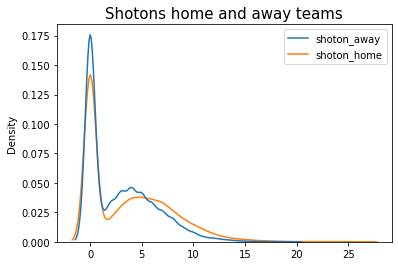

In [26]:
sns.kdeplot(data=df_mt[["shoton_away", "shoton_home"]], shade=False,legend=True)
plt.title("Shotons home and away teams", fontsize = 15)
plt.show()

<b>Highlight:</b> According to the following graph, it seems that home teams tend to make more shots on goal than away teams.

In [27]:
avg_shoton = (df_mt.groupby(['season','country', 'league'])
     .agg(Avg_shoton_away=('shoton_away','mean'),
         Avg_shoton_home=('shoton_home','mean'))
     .reset_index()
    )
avg_shoton.head(4)

,season,country,league,Avg_shoton_away,Avg_shoton_home
0,2008/2009,England,England Premier League,5.097368,6.850000
1,2008/2009,Germany,Germany 1. Bundesliga,1.014184,1.546099
2,2008/2009,Italy,Italy Serie A,2.107895,2.552632
3,2008/2009,Netherlands,Netherlands Eredivisie,2.500000,7.000000


In [28]:
# Difference in Population Means hypothesis testing
sm.stats.ztest(avg_shoton.Avg_shoton_away, avg_shoton.Avg_shoton_home)

(-1.9126104212007458, 0.055797944564686085)

<b>Conclusion:</b> We can see that p-value/2 < 0.05. Thus, we reject H0 hyppthesis, and conclude that avg. shoton number difference means between home and away teams is significant different from 0.

We can interpret that avg. shoton number between home and away teams differs.

In [29]:
diff_mu1 = avg_shoton['Avg_shoton_away'].mean()
diff_sd1 = avg_shoton['Avg_shoton_home'].std()
diff_n = len(avg_shoton['Avg_shoton_away'])

t_stat = (diff_mu1/(diff_sd1/math.sqrt(diff_n)))
print("t-statistics:",t_stat)

lbc = diff_mu1 - t_stat*(diff_sd1/math.sqrt(diff_n))
ubc = diff_mu1 + t_stat*(diff_sd1/math.sqrt(diff_n))
print("95% confidence interval of avg. shoton difference:")
(lbc,ubc)

t-statistics: 7.725654536150848
95% confidence interval of avg. shoton difference:


(0.0, 5.948348631113871)

<b>Conclusion:</b> We can see that avg. shoton number difference between home and away teams might vary from 0 to 5.9 shots.

#### Based on crossing

Crossing -  Determines the quality and accuracy of a player's pass towards the center of the field, near the opponent's goal.

This attribute could be also defining the team confidence and home/away advantage. Thus we will form the statement and hypothesis:

<b><i>Home league team cross is higher than away league team</i></b>


<b>H0: Cross difference means between Home and Away league teams is equal.</b> (μ1=μ2)

<b> H1: Cross difference means between Home and Away league teams is significant different from 0. (μ1≠μ2) </b>

In [30]:
df_mt = df_m.dropna( how='any',
                          subset=['cross'])
df_mt.shape

(14155, 121)

In [31]:
df_mt["cross_home"] = np.nan
df_mt["cross_away"] = np.nan
clear_output()

In [32]:
df_mt["cross_home"] = df_mt.apply(lambda x : extract_xml(x,"cross","team","home"), axis = 1)
df_mt["cross_away"] = df_mt.apply(lambda x : extract_xml(x,"cross","team","away"), axis = 1)
clear_output()

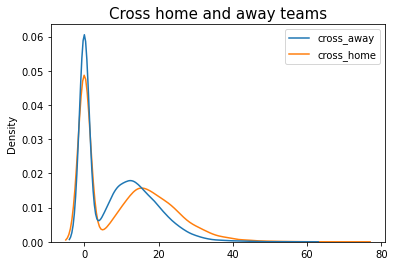

In [33]:
sns.kdeplot(data=df_mt[["cross_away", "cross_home"]], shade=False,legend=True)
plt.title("Cross home and away teams", fontsize = 15)
plt.show()

<b>Highlight:</b> We can see that home teams tend to make more passes, averaging around 20.

In [34]:
avg_cross = (df_mt.groupby(['season','country', 'league'])
     .agg(Avg_cross_away=('cross_away','mean'),
         Avg_cross_home=('cross_home','mean'))
     .reset_index()
    )
avg_cross.head(4)

# Difference in Population Means hypothesis testing
sm.stats.ztest(avg_cross.Avg_cross_away, avg_cross.Avg_cross_home)

(-1.7483494600454468, 0.08040353364472279)

<b>Conclusion:</b> We can see that p-value/2 < 0.05. Thus, we reject H0 hyppthesis, and conclude that avg. cross  difference means between home and away teams is significant different from 0.

We can interpret that avg. cross between home and away teams differs.

In [35]:
diff_mu1 = avg_cross['Avg_cross_away'].mean()
diff_sd1 = avg_cross['Avg_cross_home'].std()
diff_n = len(avg_cross['Avg_cross_away'])

t_stat = (diff_mu1/(diff_sd1/math.sqrt(diff_n)))
print("t-statistics:",t_stat)

lbc = diff_mu1 - t_stat*(diff_sd1/math.sqrt(diff_n))
ubc = diff_mu1 + t_stat*(diff_sd1/math.sqrt(diff_n))
print("95% confidence interval of avg. cross difference:")
(lbc,ubc)

t-statistics: 7.874910363364775
95% confidence interval of avg. cross difference:


(0.0, 18.647966007863086)

<b>Conclusion:</b> We can see that avg. cross value difference between home and away teams might vary from 0 to 18.6 shots.

#### Based on goals

Home league teams total goals distribution is more skewed right - more goals scores, than away team.

In [36]:
htg = (df_m.groupby(['home_team_goal'])
            .agg(HomeCount=('match_api_id','count'))
            .reset_index()
            .rename(columns={'home_team_goal':'team_goal'})
        )

atg = (df_m.groupby(['away_team_goal'])
            .agg(AwayCount=('match_api_id','count'))
            .reset_index()
              .rename(columns={'away_team_goal':'team_goal'}))

goal_count = pd.merge(htg,atg,
                      how='outer',
                      on = 'team_goal').fillna(0)
goal_count

,team_goal,HomeCount,AwayCount
0,0,5391,7898.0
1,1,7719,8290.0
2,2,5817,4760.0
3,3,3051,1991.0
4,4,1287,683.0
5,5,427,199.0
6,6,151,59.0
7,7,37,9.0
8,8,9,5.0
9,9,4,1.0


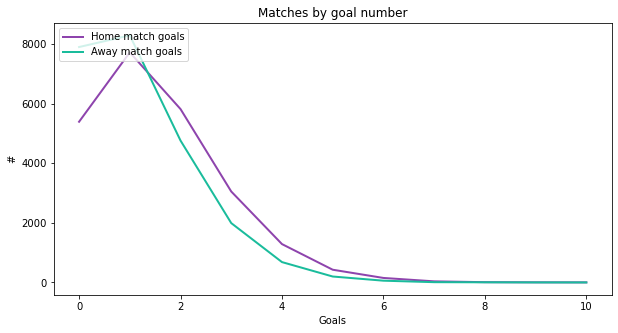

In [37]:
fig, ax = plt.subplots(figsize = (10,5))

goals = goal_count.team_goal.unique().tolist()

line1 = plt.plot(goals, goal_count.HomeCount, 
                 linewidth = 2.0, 
                 color = '#8E44AD', 
                 label = 'Home match goals')
line2 = plt.plot(goals, goal_count.AwayCount, 
                 linewidth = 2.0, 
                 color = '#1ABC9C', 
                 label = 'Away match goals')

plt.legend(loc = 'upper left')

plt.xlabel('Goals')
plt.ylabel('#')
plt.title('Matches by goal number')
plt.show()

<b>Highlight:</b> We can see that more home team matches are with  2 or more goals than away teams.

## Conclusions

<b>Leagues and teams</b>
- There is 11 leagues in 11 countries.
- Most of the countries and leagues has similar high number of teams. Around 30 teams. Most teams having leagues are: France Ligue 1 (35), England Premier League (34), Spain LIGA BBVA (33). While least teams having leagues are: Switzerland Super League (15), Scotland Premier League (17), Poland Ekstraklasa (22).
- The most goals in total scores leagues: Spain LIGA BBVA, England Premier League, Italy Serie A. While the fewest goals scores leagues: Switzerland Super League, Poland Ekstraklasa, Scotland Premier League.
- Based on macthes mean, best scores: Netherlands Eredivisie (3.1), Switzerland Super League (2.9), Germany 1. Bundesliga (2.9). Lowest matches goals mean is on: Poland Ekstraklasa (2.4), France Ligue 1 (2.4), Portugal Liga ZON Sagres (2.5).

<b>Home advantage</b>
If home advantage playing the match and perform better appears, it was analysed base on 3 attributes: shoton, cross and goals.
- Based on shoton distribution it seems that home teams tend to make more shots on goal than away teams.
H0: Shoton number difference means between Home and Away league teams is equal. (μ1=μ2)
After testing hypothesis, we rejected H0 and conclude that avg. shoton number difference means between home and away teams is significant different from 0. We can interpret that avg. shoton number between home and away teams differs. And avg. shoton number difference between home and away teams might vary from 0 to 5.9 shots.
- H0: Cross difference means between Home and Away league teams is equal. (μ1=μ2). Based on distribution - home teams tend to make more passes, averaging around 20.
We reject H0 hyppthesis, and conclude that avg. cross difference means between home and away teams is significant different from 0. We can interpret that avg. cross between home and away teams differs. Avg. cross value difference between home and away teams might vary from 0 to 18.6 shots.
- Based on goal number we saw that more home team matches are with 2 or more goals than away teams. Which allows make assumption that home teams might score more goals than away teams.